# 1-Step SARSA Using Acme

This notebook shows the tabular reinforcement learning algorithm, 1-step SARSA applied to the Taxi problem (it also works on CliffWalking and FrozenLake) from Open AI's gym. 1-step SARSA is an on-policy Temporal Difference control algorithm. The algorithm is defined by: 
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha [R_{t + 1} + \gamma Q(S_{t + 1}, A_{t + 1}) - Q(S_t, A_t)]$$
, where $Q$ is the learned action-value function, $R$ is the reward, $A$ is the action, $\alpha$ is the step size, $\gamma$ is the discount rate and $t$ is the time step.

For more information on the SARSA algorithm see section 6.4 of [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/RLbook2018.pdf). For alternative implementations of 1-step SARSA see: [SARSA Example by Denny Britz](https://github.com/dennybritz/reinforcement-learning/blob/master/TD/SARSA%20Solution.ipynb), [Intro to DeepMind’s Reinforcement Learning Framework “Acme”](https://towardsdatascience.com/deepminds-reinforcement-learning-framework-acme-87934fa223bf).

In [1]:
import acme
from acme import types
from acme.wrappers import GymWrapper
from acme.environment_loop import EnvironmentLoop
from acme.utils.loggers import InMemoryLogger
import pandas as pd
import gym
import dm_env
import numpy as np
import tree

## Patch The Acme GymWrapper Class

In [2]:
def patched_step(self, action: types.NestedArray) -> dm_env.TimeStep:
    """Steps the environment."""
    if self._reset_next_step:
        return self.reset()

    # Added change to include truncated paramater
    observation, reward, done, truncated, info = self._environment.step(action)
    self._reset_next_step = done
    self._last_info = info

    # Convert the type of the reward based on the spec, respecting the scalar or
    # array property.
    reward = tree.map_structure(
        lambda x, t: (  # pylint: disable=g-long-lambda
            t.dtype.type(x)
            if np.isscalar(x) else np.asarray(x, dtype=t.dtype)),
        reward,
        self.reward_spec())

    if done:
        if truncated:
            return dm_env.truncation(reward, observation)
        return dm_env.termination(reward, observation)
    return dm_env.transition(reward, observation)

def patched_reset(self) -> dm_env.TimeStep:
    """Resets the episode."""
    self._reset_next_step = False
    observation, info = self._environment.reset()
    # Reset the diagnostic information.
    self._last_info = None
    return dm_env.restart(observation)


GymWrapper.step = patched_step
GymWrapper.reset = patched_reset

## Select Environment

In [3]:
# Type of environment, options include:
# Taxi-v3, CliffWalking-v0, FrozenLake-v1
env_type = "Taxi-v3"
# Create the environment
env = GymWrapper(gym.make(env_type, render_mode=None))

# Number of possible states and actions
num_states = env.observation_space.n 
num_actions = env.action_space.n

# Action-value function, 
# initialized to 0 for all states and actions
Q = np.zeros([num_states, num_actions])

In [4]:
# print env specs
env_specs = env.observation_space, env.action_space, env.reward_range # env.observation_spec()
print('Observation Spec:', env.observation_space)
print('Action Spec:', env.action_space)
print('Reward Spec:', env.reward_range)

Observation Spec: Discrete(500)
Action Spec: Discrete(6)
Reward Spec: (-inf, inf)


## Create SARSA Agent

In [5]:
class SARSAAgent(acme.Actor):

    def __init__(self, Q, num_states, num_actions, gamma=0.99, epsilon=0.01, alpha=0.618):

        self.Q = Q

        self.num_states = num_states
        self.num_actions = num_actions 
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha


    def policy_fn(self, state):
        # Create a distribution of actions and divide the epsilon probability between all actions
        action_dist = np.ones(self.num_actions, dtype=float) * self.epsilon / self.num_actions
        # Find the best action
        best_action = np.argmax(self.Q[state, :])
        # Set probability for the best action to (1 - epsilon)
        action_dist[best_action] += (1.0 - self.epsilon)
        return action_dist


    def select_action(self, observation: types.NestedArray):
        state = observation
        action_dist = self.policy_fn(state)
        action = np.random.choice(np.arange(num_actions), p=action_dist)
        return action

    def observe_first(self, timestep: dm_env.TimeStep):
        self.timestep = timestep

    def observe(self, action: types.NestedArray, next_timestep: dm_env.TimeStep):
        self.action = action
        self.next_timestep = next_timestep

    def update(self, wait: bool = False):
        # get variables for convenience
        state = self.timestep.observation
        _, reward, discount, next_state = self.next_timestep
        action = self.action
        
        # sample a next action
        next_action_dist = self.policy_fn(next_state)
        next_action = np.random.choice(np.arange(self.num_actions), p=next_action_dist)

        # compute and apply the TD error
        self.Q[state][action] += self.alpha * (reward + self.gamma * self.Q[next_state, next_action] - self.Q[state, action]) 
        
        # finally, set timestep to next_timestep
        self.timestep = self.next_timestep        

        

In [6]:
sarsa = SARSAAgent(Q, num_states, num_actions)

## Learn The Optimal Action-Value Function

In [7]:
loop = EnvironmentLoop(env, sarsa, logger=InMemoryLogger())
loop.run(500)

/home/ubuntu22/repos/reinforcement-learning-algorithms/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Plot The Results

In [8]:
logger_df = pd.DataFrame(loop._logger.data)
logger_df.head()

,episode_length,episode_return,steps_per_second,episodes,steps
0,1043,-2327.0,22929.785214,1,1043
1,705,-1548.0,28340.706748,2,1748
2,494,-1211.0,27955.990285,3,2242
3,935,-1958.0,28030.378820,4,3177
4,272,-269.0,26384.761165,5,3449


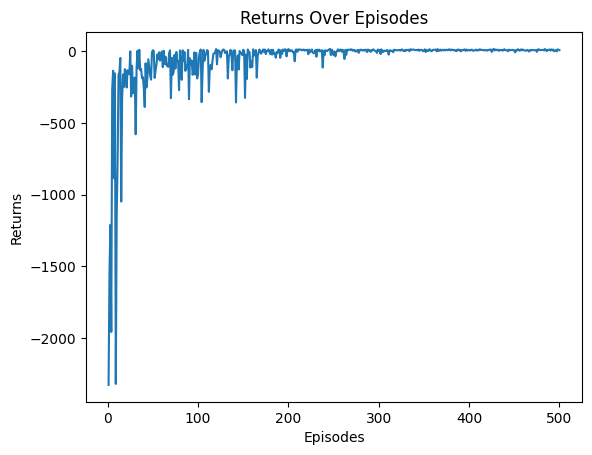

In [9]:
import matplotlib.pyplot as plt

plt.plot(logger_df["episodes"], logger_df["episode_return"])
plt.title("Returns Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Returns")
plt.show()

## Run $q_{\pi}$ On An Example

In [12]:
# Run the algorithm in inferencing mode and 
# observe its performance
env = gym.make(env_type, render_mode="human")
state, info = env.reset(seed=48)
G = 0
num_steps = 0
terminated = False

while not terminated:
    action = np.argmax(Q[state, :]) 
    state, reward, terminated, truncated, info = env.step(action)
    G += reward
    num_steps += 1

print(f'Total Reward: {G}, Steps Taken: {num_steps}')

env.close()

Total Reward: 5, Steps Taken: 16
